In [1]:
!pip install lightgbm


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install scikit-learn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install -U scikit-learn lightgbm


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import sklearn
print(sklearn.__version__)


1.7.2


In [3]:
from pathlib import Path
import json, numpy as np, pandas as pd
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd

# 1) repo 루트/노트북 위치에 따라 data_pipeline 경로 자동 탐색
candidates = [
    Path.cwd() / "app" / "data_pipeline",
    Path.cwd().parents[0] / "data_pipeline",
    Path.cwd().parents[0] / "app" / "data_pipeline",
    Path.cwd().parents[1] / "app" / "data_pipeline",
    Path("python-server/app/data_pipeline").resolve(),
]
BASE = next((p for p in candidates if p.exists()), None)
if BASE is None:
    raise FileNotFoundError("data_pipeline 폴더를 찾지 못했습니다. 노트북 위치를 확인하세요.")
    
TR = BASE / "features_train.csv"
TE = BASE / "features_test.csv"
OUT_PRED    = BASE / "predictions.csv"
MODEL_PATH  = BASE / "lightgbm_model.pkl"
FEATS_JSON  = BASE / "lightgbm_features.json"
METRICS_CSV = BASE / "metrics_eval.csv"

ID_KEYS = ["warehouse_id","store_id","sku_id","region","target_date","split"]
TARGET = "y"
VAL_WEEKS = 12                  # 마지막 12주 검증
LEAKY = {"actual_order_qty", "share_norm", "promo_flag"}  # 누수 위험 피처

print("BASE:", BASE)
print("Exists? TR:", TR.exists(), "TE:", TE.exists())


BASE: C:\Users\chosw\ORDER101_DEMAND_FORECAST\be18-fin-SYNERGY-ORDER101\python-server\app\data_pipeline
Exists? TR: True TE: True


In [4]:
# 데이터 로드, 유틸 함수
def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff  = np.abs(y_true - y_pred)
    denom = np.where(denom==0, 1.0, denom)
    return float(np.mean(diff / denom) * 100.0)

def mape(y_true, y_pred):
    denom = np.where(y_true==0, 1.0, y_true)
    return float((np.abs((y_true - y_pred) / denom)).mean() * 100.0)

def add_prev_flags(df: pd.DataFrame) -> pd.DataFrame:
    # 현재주의 promo_flag는 누수 → 이전주만 사용
    if "promo_flag" in df.columns:
        df["promo_flag_prev"] = (
            df.groupby(["warehouse_id","store_id","sku_id"])["promo_flag"]
              .shift(1).fillna(0)
        )
    return df

def build_features(df: pd.DataFrame) -> list:
    ignore = set(ID_KEYS + [TARGET, "actual_order_qty"])
    numeric_cols = set(df.select_dtypes(include=["number","bool"]).columns.tolist())
    feats = [c for c in df.columns if c in numeric_cols and c not in ignore and c not in LEAKY]
    if "promo_flag_prev" in df.columns and "promo_flag_prev" not in feats:
        feats.append("promo_flag_prev")
    # 중복 제거
    feats = list(dict.fromkeys(feats))
    return feats

def drop_low_variance(df_train: pd.DataFrame, cols, nunique_thresh=1, var_thresh=1e-8):
    nun = df_train[cols].nunique()
    low_nun = nun[nun <= nunique_thresh].index.tolist()
    var = df_train[cols].var(numeric_only=True).fillna(0.0)
    low_var = var[var <= var_thresh].index.tolist()
    drop = sorted(set(low_nun + low_var))
    keep = [c for c in cols if c not in drop]
    return keep, drop

tr = pd.read_csv(TR, parse_dates=["target_date"])
te = pd.read_csv(TE, parse_dates=["target_date"])

tr = add_prev_flags(tr); te = add_prev_flags(te)
features = build_features(tr)

# 결측 처리
for c in features:
    if tr[c].dtype.kind in "fi":
        tr[c] = tr[c].fillna(0.0); te[c] = te[c].fillna(0.0)
    else:
        tr[c] = tr[c].fillna(0);   te[c] = te[c].fillna(0)

# 상수/저분산 피처 제거
features, dropped = drop_low_variance(tr, features)
print("사용 피처 수:", len(features))
print(features)
if dropped:
    print("🔎 제거된 상수/저분산 피처:", dropped)


사용 피처 수: 33
['lag_1', 'lag_2', 'lag_4', 'lag_8', 'lag_12', 'ma_4', 'ma_8', 'ma_12', 'year', 'weekofyear', 'month', 'sin_week', 'cos_week', 'avg_temp_c', 'cdd', 'hdd', 'precip_mm', 'heat_wave', 'cold_wave', 'himart_sales_krw', 'himart_sales_index', 'holiday_index', 'marketing_score', 'seasonal_peak', 'back_to_school', 'avg_temp_c_ma4', 'cdd_ma4', 'hdd_ma4', 'precip_mm_ma4', 'himart_sales_index_ma4', 'holiday_index_ma4', 'marketing_score_ma4', 'promo_flag_prev']


In [5]:
# 시계열 검증 분리(마지막 12주) & 학습
# 마지막 12주를 검증으로 분리
keys = ["warehouse_id","store_id","sku_id"]
tr2 = tr.sort_values(keys + ["target_date"]).copy()
tr2["idx_in_grp"] = tr2.groupby(keys).cumcount()
tr2["grp_size"]   = tr2.groupby(keys)[TARGET].transform("size")
tr2["is_val"]     = (tr2["grp_size"] - tr2["idx_in_grp"]) <= VAL_WEEKS
tr_fit = tr2.loc[~tr2["is_val"]].drop(columns=["idx_in_grp","grp_size","is_val"])
tr_val = tr2.loc[ tr2["is_val"]].drop(columns=["idx_in_grp","grp_size","is_val"])

X_tr, y_tr = tr_fit[features], tr_fit[TARGET]
X_va, y_va = tr_val[features], tr_val[TARGET]

# LightGBM 설정(규제 + 조기중지)
model = LGBMRegressor(
    objective="poisson",
    n_estimators=3000, learning_rate=0.02,
    num_leaves=31, max_depth=8,
    min_child_samples=128,
    min_gain_to_split=0.02,
    subsample=0.65, subsample_freq=1,
    colsample_bytree=0.65,
    reg_alpha=2.0, reg_lambda=2.0,
    random_state=42, verbosity=-1
)
model.fit(
    X_tr, y_tr,
    eval_set=[(X_va, y_va)],
    eval_metric="mae",
    callbacks=[early_stopping(200, first_metric_only=True), log_evaluation(200)]
)

best_iter = getattr(model, "best_iteration_", None)
print("best_iteration:", best_iter)


Training until validation scores don't improve for 200 rounds
[200]	valid_0's l1: 18.1467	valid_0's poisson: -478.17
[400]	valid_0's l1: 12.2368	valid_0's poisson: -480.333
[600]	valid_0's l1: 11.5203	valid_0's poisson: -480.756
[800]	valid_0's l1: 11.245	valid_0's poisson: -480.901
[1000]	valid_0's l1: 11.3161	valid_0's poisson: -480.961
Early stopping, best iteration is:
[823]	valid_0's l1: 11.2367	valid_0's poisson: -480.909
Evaluated only: l1
best_iteration: 823


In [6]:
# 테스트(=features_test.csv 전체) 평가
te_pred = np.clip(model.predict(te[features], num_iteration=best_iter), 0, None)
te = te.copy()
te["y_pred"] = te_pred

mae   = mean_absolute_error(te[TARGET], te_pred)
_mape = mape(te[TARGET].values, te_pred)
_smape= smape(te[TARGET].values, te_pred)
print(f"MAE={mae:.4f} | MAPE={_mape:.2f}% | SMAPE={_smape:.2f}% (n={len(te)})")

# SKU별 집계(상위 SKU 뽑을 때 쓰자)
sku_eval = (
    te.groupby("sku_id")
      .agg(n=("y","size"), mae=("y", lambda s: float(np.mean(np.abs(s - te.loc[s.index, "y_pred"])))))
      .sort_values("n", ascending=False)
)
sku_eval.head()


MAE=14.9755 | MAPE=76.63% | SMAPE=22.57% (n=33800)


,n,mae
sku_id,,
AC-CAR-16P-2024,520,13.414572
AC-LG-STAND-18P-2024,520,18.796043
AC-LG-WS-6P-2024,520,6.149870
AC-SAM-WF-18P-2024,520,15.905397
AIR-LG-PURI-58-2024,520,23.192366


MAE for VAC-XIA-ROBO-2024: 20.212 over 52 days


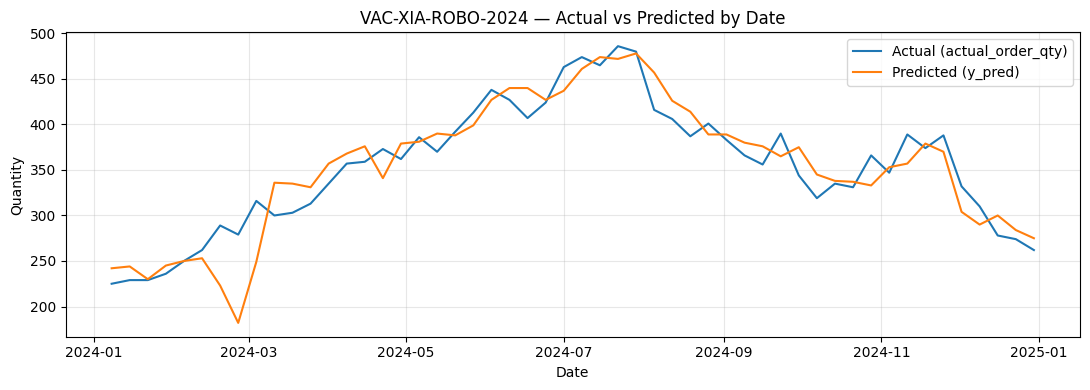

MAE for AC-CAR-16P-2024: 89.538 over 52 days


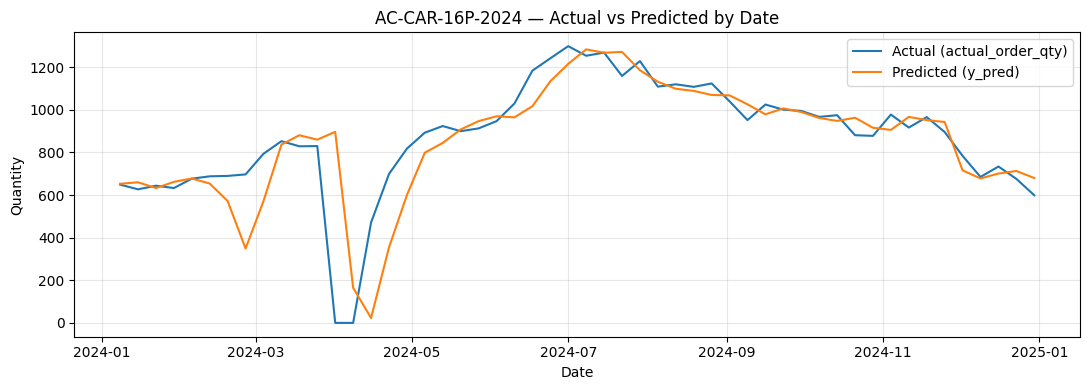

MAE for AC-LG-STAND-18P-2024: 116.212 over 52 days


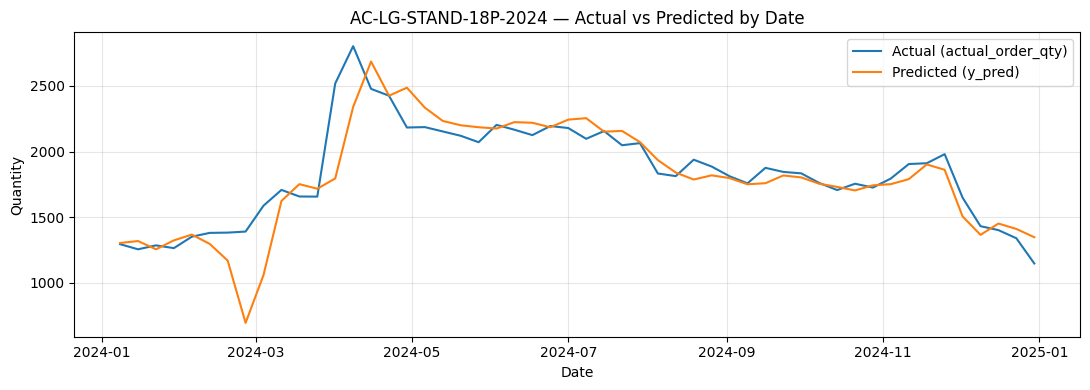

MAE for MON-DEL-24FHD-2023: 37.673 over 52 days


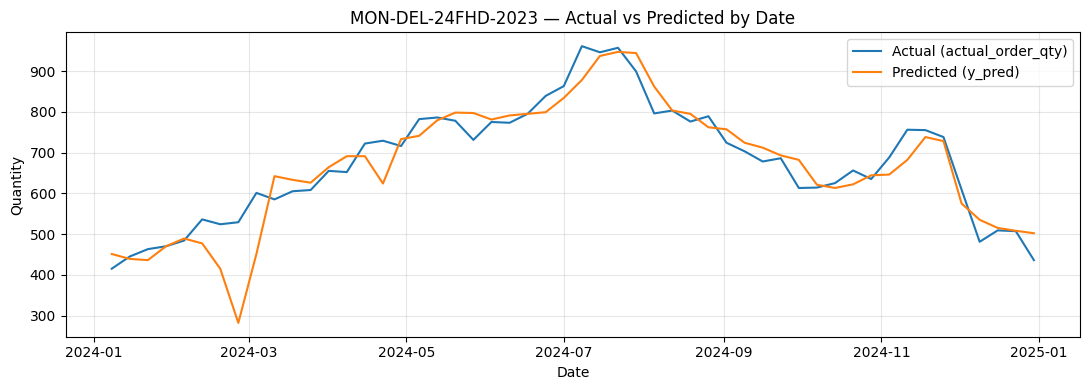

MAE for WM-MIE-DRUM-9K-2023: 41.269 over 52 days


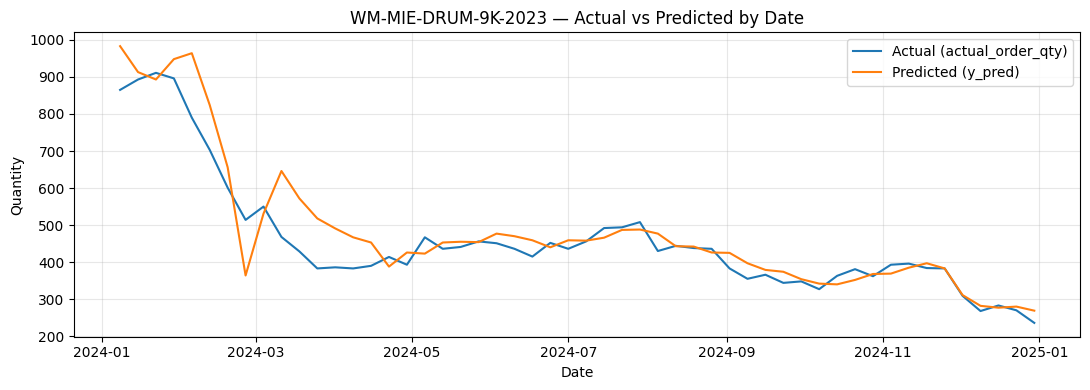

MAE for MIX-CUI-HAND-2024: 169.635 over 52 days


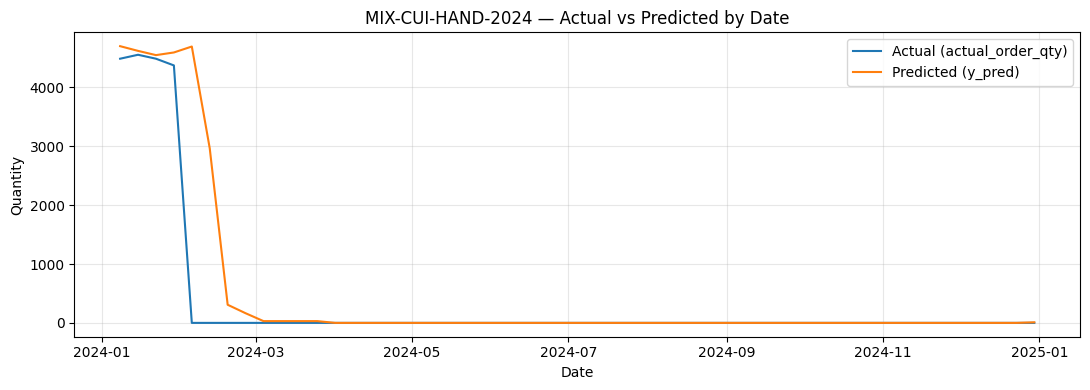

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
def test(SKU):
    # --- file paths (edit if needed) ---
    FEATURES_PATH = BASE / "features_test.csv"
    PRED_PATH     = BASE / "predictions.csv"
    #SKU           = "VAC-XIA-ROBO-2024"
    
    # --- load ---
    feat = pd.read_csv(FEATURES_PATH, parse_dates=["target_date"])
    pred = pd.read_csv(PRED_PATH,     parse_dates=["target_date"])
    
    # --- filter SKU ---
    feat_sku = feat[feat["sku_id"] == SKU].copy()
    pred_sku = pred[pred["sku_id"] == SKU].copy()
    
    # --- aggregate by date in case there are multiple rows per target_date (e.g., by store/region) ---
    # features_test.csv: we expect "actual_order_qty"
    actual_by_day = (
        feat_sku.groupby("target_date", as_index=False)["actual_order_qty"]
        .sum()
        .rename(columns={"actual_order_qty": "y_actual"})
    )
    
    # predictions.csv: we expect "y_pred"
    pred_by_day = (
        pred_sku.groupby("target_date", as_index=False)["y_pred"]
        .sum()
    )
    
    # --- align by common dates (inner join) ---
    df = pd.merge(actual_by_day, pred_by_day, on="target_date", how="inner").sort_values("target_date")
    
    if df.empty:
        raise ValueError(f"No overlapping dates found for SKU={SKU}. "
                         "Check that both files contain this SKU and matching target_date values.")
    
    # --- (optional) quick metrics ---
    try:
        mae = (df["y_actual"] - df["y_pred"]).abs().mean()
        print(f"MAE for {SKU}: {mae:.3f} over {len(df)} days")
    except Exception as e:
        print("Could not compute MAE:", e)
    
    # --- plot ---
    plt.figure(figsize=(11, 4))
    plt.plot(df["target_date"], df["y_actual"], label="Actual (actual_order_qty)")
    plt.plot(df["target_date"], df["y_pred"],   label="Predicted (y_pred)")
    plt.title(f"{SKU} — Actual vs Predicted by Date")
    plt.xlabel("Date")
    plt.ylabel("Quantity")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


test("VAC-XIA-ROBO-2024")
test("AC-CAR-16P-2024")
test("AC-LG-STAND-18P-2024")
test("MON-DEL-24FHD-2023")
test("WM-MIE-DRUM-9K-2023")
test("MIX-CUI-HAND-2024")

In [78]:
# 예측 저장
keep_ids = [c for c in ["warehouse_id","store_id","sku_id","region","target_date"] if c in te.columns]
out = te[keep_ids + [TARGET, "y_pred"]].copy()
out["y_pred"] = out["y_pred"].round(0).astype(int)
out.to_csv(OUT_PRED, index=False)

# 모델/피처/메트릭 저장
import joblib
joblib.dump(model, MODEL_PATH)
with open(FEATS_JSON, "w", encoding="utf-8") as f:
    json.dump(features, f, ensure_ascii=False, indent=2)
pd.DataFrame({
    "metric":["mae","mape","smape"],
    "value":[mae, _mape, _smape],
    "best_iteration":[best_iter]*3
}).to_csv(METRICS_CSV, index=False)

print("saved:", OUT_PRED.name, "| model:", MODEL_PATH.name, "| feats:", FEATS_JSON.name, "| metrics:", METRICS_CSV.name)


saved: predictions.csv | model: lightgbm_model.pkl | feats: lightgbm_features.json | metrics: metrics_eval.csv


In [79]:
# 과적합 원인 찾기
print("Train date range:", tr["target_date"].min(), "→", tr["target_date"].max())
print("Test  date range:", te["target_date"].min(), "→", te["target_date"].max())

# 날짜 겹치는지
overlap = pd.merge(
    tr[["warehouse_id","store_id","sku_id","target_date"]],
    te[["warehouse_id","store_id","sku_id","target_date"]],
    on=["warehouse_id","store_id","sku_id","target_date"],
    how="inner"
)
print("⚠️ overlap rows:", len(overlap))

# 피처에 누수 의심 변수 포함되어 있는지
suspect_cols = [c for c in features if any(k in c.lower() for k in ["order", "qty", "actual", "target"])]
print("⚠️ 누수 의심 피처:", suspect_cols)

# 이동평균 피처 확인
ma_cols = [c for c in features if "ma" in c.lower()]
print("이동평균 피처:", ma_cols)


Train date range: 2016-02-29 00:00:00 → 2024-01-01 00:00:00
Test  date range: 2024-01-08 00:00:00 → 2024-12-30 00:00:00
⚠️ overlap rows: 0
⚠️ 누수 의심 피처: []
이동평균 피처: ['ma_4', 'ma_8', 'ma_12', 'himart_sales_krw', 'himart_sales_index', 'marketing_score', 'avg_temp_c_ma4', 'cdd_ma4', 'hdd_ma4', 'precip_mm_ma4', 'himart_sales_index_ma4', 'holiday_index_ma4', 'marketing_score_ma4']


In [81]:
from pathlib import Path
import pandas as pd

# 후보 경로들을 순서대로 점검
candidates = [
    Path.cwd() / "app" / "data_pipeline",
    Path.cwd().parents[0] / "data_pipeline",
    Path.cwd().parents[0] / "app" / "data_pipeline",
    Path.cwd().parents[1] / "app" / "data_pipeline",
    Path("python-server/app/data_pipeline").resolve(),
]

BASE = next((p for p in candidates if p.exists()), None)
print("BASE:", BASE)

if BASE is None:
    raise FileNotFoundError("data_pipeline 폴더를 찾지 못했습니다. 노트북 위치를 확인하세요.")

TR = BASE / "features_train.csv"
TE = BASE / "features_test.csv"

print("Exists? TR:", TR.exists(), "TE:", TE.exists())
tr = pd.read_csv(TR, parse_dates=["target_date"])
te = pd.read_csv(TE, parse_dates=["target_date"])

print("Train/Test shapes:", tr.shape, te.shape)


BASE: C:\Users\chosw\ORDER101_DEMAND_FORECAST\be18-fin-SYNERGY-ORDER101\python-server\app\data_pipeline
Exists? TR: True TE: True
Train/Test shapes: (266500, 42) (33800, 42)


In [82]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np

target = "y"
ignore = ["warehouse_id","store_id","sku_id","region","target_date","split",target]
leaky = {"actual_order_qty", "share_norm", "promo_flag"}  # 누출 방지

# --- (1) promo_flag_prev 안전 생성: 없을 때만 생성 ---
for df_ in (tr, te):
    if "promo_flag" in df_.columns and "promo_flag_prev" not in df_.columns:
        df_["promo_flag_prev"] = (
            df_.groupby(["warehouse_id","store_id","sku_id"])["promo_flag"]
              .shift(1).fillna(0)
        )

# --- (2) 피처 선택 + 중복 제거 ---
numeric_cols = tr.select_dtypes(include=["number","bool"]).columns.tolist()
features = [c for c in numeric_cols if c not in ignore and c not in leaky]
if "promo_flag_prev" in tr.columns:  # lag된 프로모만 사용
    features.append("promo_flag_prev")
# 중복 제거
features = list(dict.fromkeys(features))

print(f"사용 피처 수: {len(features)}개")
print(features)

# NaN 처리
for c in features:
    if tr[c].dtype.kind in "fi":
        tr[c] = tr[c].fillna(0.0); te[c] = te[c].fillna(0.0)
    else:
        tr[c] = tr[c].fillna(0);   te[c] = te[c].fillna(0)

# 학습
model = LGBMRegressor(
    n_estimators=1200, learning_rate=0.01,
    subsample=0.9, colsample_bytree=0.8,
    num_leaves=31, random_state=42
)
model.fit(tr[features], tr[target])

# 예측/평가
te_pred = np.clip(model.predict(te[features]), 0, None)
mae  = mean_absolute_error(te[target], te_pred)
mape = (np.abs(te[target] - te_pred) / np.maximum(te[target], 1)).mean() * 100
print(f"MAE={mae:.4f}, MAPE={mape:.2f}%")


사용 피처 수: 33개
['lag_1', 'lag_2', 'lag_4', 'lag_8', 'lag_12', 'ma_4', 'ma_8', 'ma_12', 'year', 'weekofyear', 'month', 'sin_week', 'cos_week', 'avg_temp_c', 'cdd', 'hdd', 'precip_mm', 'heat_wave', 'cold_wave', 'himart_sales_krw', 'himart_sales_index', 'holiday_index', 'marketing_score', 'seasonal_peak', 'back_to_school', 'avg_temp_c_ma4', 'cdd_ma4', 'hdd_ma4', 'precip_mm_ma4', 'himart_sales_index_ma4', 'holiday_index_ma4', 'marketing_score_ma4', 'promo_flag_prev']
MAE=8.3996, MAPE=9.50%


In [83]:
import numpy as np
import pandas as pd

target = "y"

# 아직 예측 안했다면 생성
if "y_pred" not in te.columns:
    te["y_pred"] = np.clip(model.predict(te[features]), 0, None)

# 기본 정렬
te = te.sort_values(["warehouse_id","store_id","sku_id","target_date"]).reset_index(drop=True)


In [84]:
# SKU 단위 MAE / MAPE 요약
def mape(a, p):
    denom = np.maximum(a, 1)  # 0-division 방지
    return (np.abs(a - p) / denom).mean() * 100

sku_eval = (te
    .groupby("sku_id")
    .apply(lambda g: pd.Series({
        "n": len(g),
        "qty_sum": g[target].sum(),
        "mae": np.abs(g[target]-g["y_pred"]).mean(),
        "mape": mape(g[target].values, g["y_pred"].values)
    }))
    .sort_values(["qty_sum","mape"], ascending=[False, True])
)
sku_eval.head(10)


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_70748\3793928618.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,n,qty_sum,mae,mape
sku_id,,,,
MIX-BRV-STAND-5L-2024,520.0,345265.0,34.479000,5.487179
WAT-SAM-GAL-45-2024,520.0,172608.0,18.932499,5.934626
WAT-APL-AW-41-2024,520.0,172562.0,19.396367,6.054396
TOA-BRN-2S-2024,520.0,142566.0,15.962719,6.163182
TOA-PHI-2S-2024,520.0,142262.0,15.758735,6.042345
MW-SAM-30L-2024,520.0,126144.0,13.803815,6.017553
DW-SAM-12P-2024,520.0,120345.0,13.886398,6.378564
DES-HP-STD-2024,520.0,120319.0,13.019832,5.947120
DES-SAM-STD-2024,520.0,120027.0,13.619345,6.261321


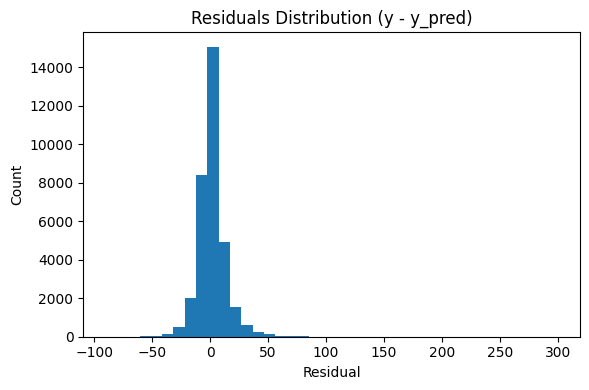

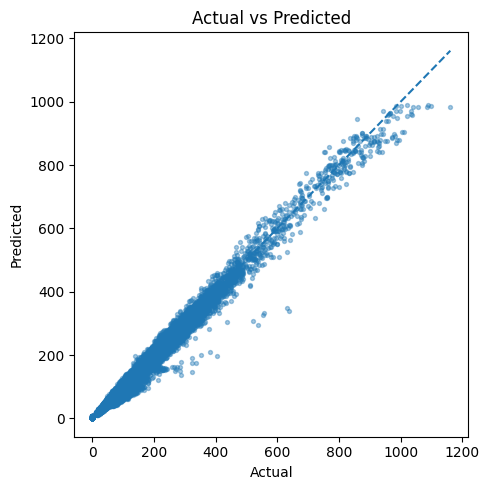

In [87]:
res = te[target] - te["y_pred"]

plt.figure(figsize=(6,4))
plt.hist(res, bins=40)
plt.title("Residuals Distribution (y - y_pred)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(te[target], te["y_pred"], s=8, alpha=0.4)
plt.plot([0, te[[target,'y_pred']].max().max()],
         [0, te[[target,'y_pred']].max().max()],
         linestyle="--")
plt.title("Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.tight_layout()
plt.show()


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_70748\1095226514.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,year,month,n,mae,mape
0,2024,1,2600.0,6.413725,11.148601
1,2024,2,2600.0,14.519904,16.858167
2,2024,3,2600.0,7.485974,8.079044
3,2024,4,3250.0,8.448396,8.801488
4,2024,5,2600.0,8.071009,7.179884
5,2024,6,2600.0,8.281610,7.180872
6,2024,7,3250.0,8.496648,7.063373
7,2024,8,2600.0,8.624791,9.655333
8,2024,9,3250.0,7.270129,8.752546
9,2024,10,2600.0,7.124347,9.399436


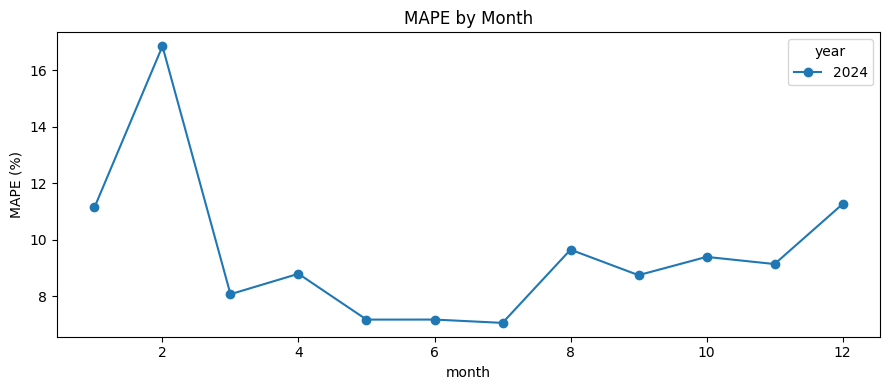

In [89]:
tmp = te.copy()
tmp["year"] = pd.to_datetime(tmp["target_date"]).dt.year
tmp["month"] = pd.to_datetime(tmp["target_date"]).dt.month
by_month = (tmp.groupby(["year","month"])
              .apply(lambda g: pd.Series({
                  "n": len(g),
                  "mae": np.abs(g[target]-g["y_pred"]).mean(),
                  "mape": mape(g[target].values, g["y_pred"].values)
              }))
              .reset_index())
display(by_month.sort_values(["year","month"]).head(24))

# 월별 MAPE 라인
pivot = by_month.pivot(index="month", columns="year", values="mape")
pivot.plot(figsize=(9,4), marker="o")
plt.title("MAPE by Month")
plt.ylabel("MAPE (%)")
plt.tight_layout()
plt.show()


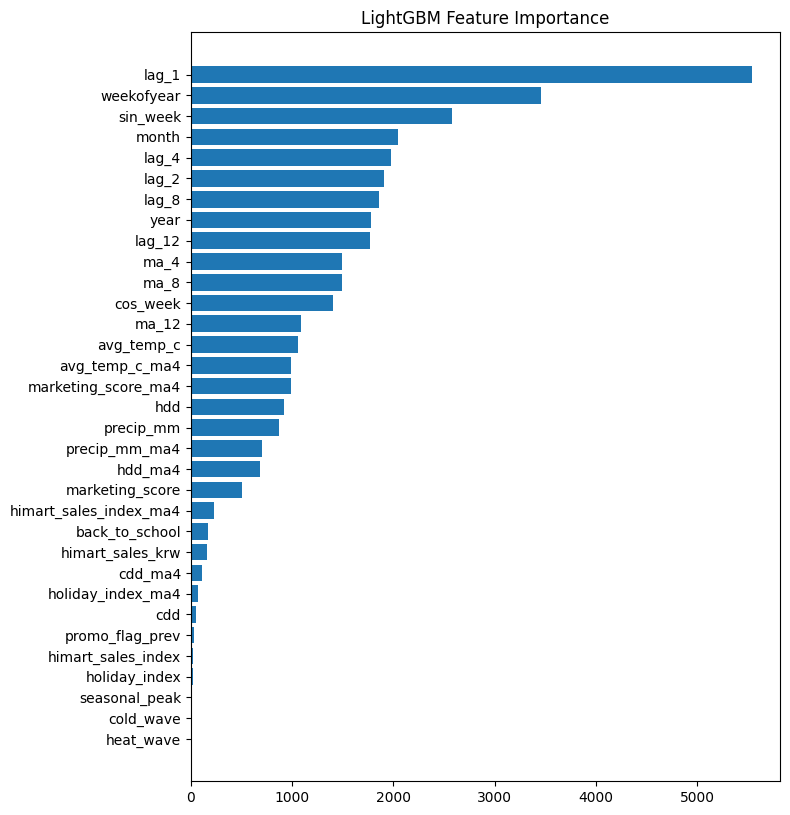

In [100]:
import numpy as np

if hasattr(model, "feature_importances_"):
    fi = pd.DataFrame({
        "feature": features,
        "importance": model.feature_importances_
    }).sort_values("importance", ascending=False)

    plt.figure(figsize=(8, max(4, 0.25*len(fi))))
    plt.barh(fi["feature"][::-1], fi["importance"][::-1])
    plt.title("LightGBM Feature Importance")
    plt.tight_layout()
    plt.show()

    fi.head(20)
else:
    print("모델이 feature_importances_를 제공하지 않습니다.")


In [92]:
import pandas as pd, pathlib as p
candidates = [
    Path.cwd() / "app" / "data_pipeline",
    Path.cwd().parents[0] / "data_pipeline",
    Path.cwd().parents[0] / "app" / "data_pipeline",
    Path.cwd().parents[1] / "app" / "data_pipeline",
    Path("python-server/app/data_pipeline").resolve(),
]
BASE = next((p for p in candidates if p.exists()), None)
df = pd.read_csv(BASE/"domain_sales_sku.csv", parse_dates=["target_date"])
print("SKU groups:", df["sku_id"].nunique())

# 같은 주차에서 SKU 간 상관이 너무 높지 않은지 대략 체크
g = (df.groupby(["sku_id","target_date"])["sku_qty"].sum().unstack(0).fillna(0))
print("Pairwise corr median:", g.corr().stack().median())


SKU groups: 65
Pairwise corr median: 0.5983245214107281


In [93]:
# 같은 week 에서 서로 다른 두 SKU의 값 비교(무작위 5주)
sids = df["sku_id"].unique()[:2]
print(df[df["sku_id"].isin(sids)].pivot_table(
    index="target_date", columns="sku_id", values="sku_qty", aggfunc="sum").dropna().head(5))

sku_id       TV-LG-LED-55-2023  TV-LG-OLED-65-2024
target_date                                       
2016-02-29                 243                 427
2020-01-07                 179                 316
2020-01-14                 175                 302
2020-01-21                 175                 303
2020-01-28                 163                 287


In [94]:
fa = pd.read_csv(BASE/"features_all.csv", parse_dates=["target_date"])
print("group ngroups:", fa.groupby(["warehouse_id","store_id","sku_id","region"]).ngroups)


group ngroups: 650


SKU 개수: 65


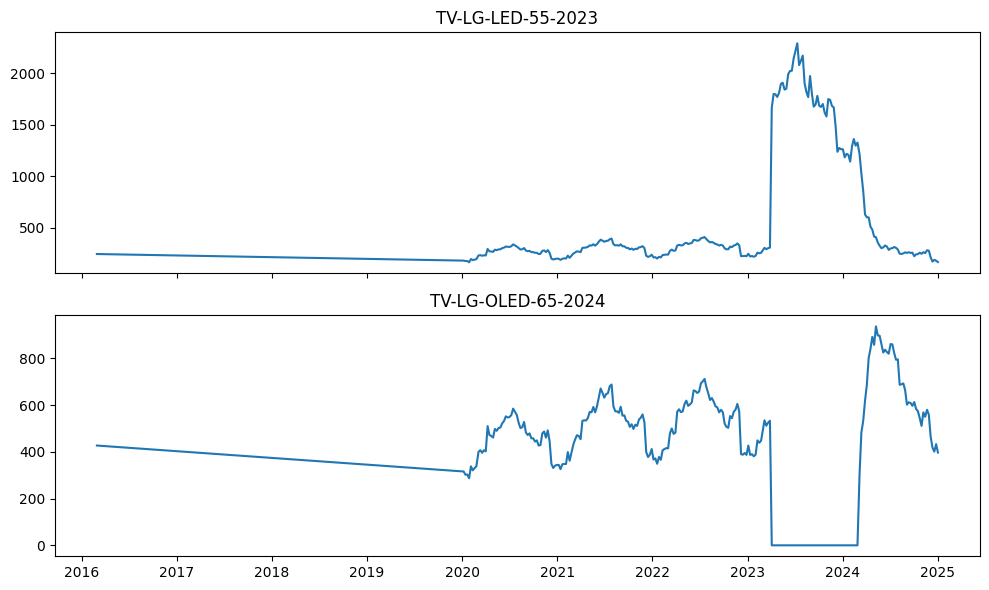

In [96]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt


candidates = [
    Path.cwd() / "app" / "data_pipeline",
    Path.cwd().parents[0] / "data_pipeline",
    Path.cwd().parents[0] / "app" / "data_pipeline",
    Path.cwd().parents[1] / "app" / "data_pipeline",
    Path("python-server/app/data_pipeline").resolve(),
]
BASE = next((p for p in candidates if p.exists()), None)
if BASE is None:
    raise FileNotFoundError("data_pipeline 폴더를 찾지 못했습니다. 노트북 위치를 확인하세요.")
    
TR = BASE / "features_train.csv"
TE = BASE / "features_test.csv"
OUT_PRED    = BASE / "predictions.csv"
MODEL_PATH  = BASE / "lightgbm_model.pkl"
FEATS_JSON  = BASE / "lightgbm_features.json"
METRICS_CSV = BASE / "metrics_eval.csv"
DOMAIN_SALE = BASE / "domain_sales_sku.csv"
FEAT_ALL = BASE / "features_all.csv"


BASE = Path("python-server/app/data_pipeline")
d  = pd.read_csv(DOMAIN_SALE, parse_dates=["target_date"])
fa = pd.read_csv(FEAT_ALL, parse_dates=["target_date"])

print("SKU 개수:", d["sku_id"].nunique())

# 서로 다른 두 SKU의 시계열 모양이 다른지 눈검
pick = d["sku_id"].drop_duplicates().head(2).tolist()
fig, axes = plt.subplots(2,1,figsize=(10,6), sharex=True)
for ax, sid in zip(axes, pick):
    gg = (d[d["sku_id"]==sid]
          .sort_values("target_date")
          .groupby("target_date")["sku_qty"].sum())
    ax.plot(gg.index, gg.values); ax.set_title(sid)
plt.tight_layout(); plt.show()


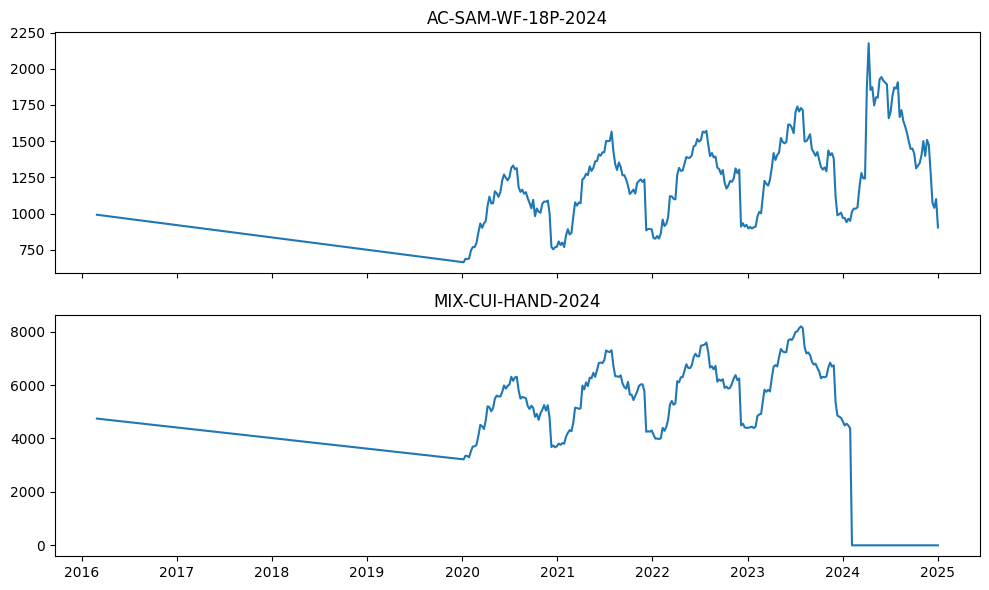

corr: -0.08095601250006929


In [98]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


candidates = [
    Path.cwd() / "app" / "data_pipeline",
    Path.cwd().parents[0] / "data_pipeline",
    Path.cwd().parents[0] / "app" / "data_pipeline",
    Path.cwd().parents[1] / "app" / "data_pipeline",
    Path("python-server/app/data_pipeline").resolve(),
]
BASE = next((p for p in candidates if p.exists()), None)

TR = BASE / "features_train.csv"
TE = BASE / "features_test.csv"
OUT_PRED    = BASE / "predictions.csv"
MODEL_PATH  = BASE / "lightgbm_model.pkl"
FEATS_JSON  = BASE / "lightgbm_features.json"
METRICS_CSV = BASE / "metrics_eval.csv"
DOMAIN_SALE = BASE / "domain_sales_sku.csv"
FEAT_ALL = BASE / "features_all.csv"



ds = pd.read_csv(DOMAIN_SALE, parse_dates=["target_date"])

pick = ds["sku_id"].drop_duplicates().sample(2, random_state=0).tolist()
fig, axes = plt.subplots(2,1, figsize=(10,6), sharex=True)
for ax, sid in zip(axes, pick):
    s = (ds[ds.sku_id==sid]
         .sort_values("target_date")
         .groupby("target_date")["sku_qty"].sum())
    ax.plot(s.index, s.values); ax.set_title(sid)
plt.tight_layout(); plt.show()

# 상관도(두 SKU가 너무 비슷하면 0.95↑)
s1 = (ds[ds.sku_id==pick[0]].sort_values("target_date")
        .groupby("target_date")["sku_qty"].sum())
s2 = (ds[ds.sku_id==pick[1]].sort_values("target_date")
        .groupby("target_date")["sku_qty"].sum())
joined = pd.concat([s1, s2], axis=1).dropna()
print("corr:", joined.corr().iloc[0,1])


In [9]:
# rolling_backtest.py (요약)
import pandas as pd, numpy as np
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
import json, time, numpy as np, pandas as pd
from lightgbm import LGBMRegressor, early_stopping
from sklearn.metrics import mean_absolute_error

candidates = [
    Path.cwd() / "app" / "data_pipeline",
    Path.cwd().parents[0] / "data_pipeline",
    Path.cwd().parents[0] / "app" / "data_pipeline",
    Path.cwd().parents[1] / "app" / "data_pipeline",
    Path("python-server/app/data_pipeline").resolve(),
]
BASE = next((p for p in candidates if p.exists()), None)

TR = BASE / "features_train.csv"
TE = BASE / "features_test.csv"
OUT_PRED    = BASE / "predictions.csv"
MODEL_PATH  = BASE / "lightgbm_model.pkl"
FEATS_JSON  = BASE / "lightgbm_features.json"
METRICS_CSV = BASE / "metrics_eval.csv"
DOMAIN_SALE = BASE / "domain_sales_sku.csv"
FEAT_ALL = BASE / "features_all.csv"
LIGHTBGM_FEAT = BASE /"lightgbm_features.json"





# ---------------- params: 빠른 디버그용 ----------------
H               = 12      # 검증 창 (주)
MIN_TRAIN_WEEKS = 40
STEP_WEEKS      = 8       # 오리진 간격
MAX_SERIES      = 50      # 최대 시계열 개수
MAX_SPLITS      = 5       # 시계열당 최대 스플릿 수 (뒤에서부터)
MAX_SECONDS     = 120     # 전체 타임아웃(초)
# ------------------------------------------------------

keys = ["warehouse_id","store_id","sku_id"]

tr = pd.read_csv(TR, parse_dates=["target_date"])
te = pd.read_csv(TE, parse_dates=["target_date"])
df = pd.concat([tr, te], ignore_index=True).sort_values(keys + ["target_date"])

# --- 학습 때와 동일한 파생 ---
if "promo_flag" not in df.columns:
    df["promo_flag"] = (df.get("share_norm", 0) > 0.25).astype(int)
if "promo_flag_prev" not in df.columns:
    df["promo_flag_prev"] = (
        df.groupby(keys)["promo_flag"].shift(1).fillna(0).astype(int)
    )

# --- 피처 목록 로드 & 교집합 ---
with open(FEATS_JSON, "r", encoding="utf-8") as f:
    features = [c for c in json.load(f) if c in df.columns]

for c in features:
    df[c] = df[c].fillna(0.0) if df[c].dtype.kind in "fi" else df[c].fillna(0)

# --- 평가 대상 시계열 (상위 판매량 기준 일부만 샘플링) ---
vol = (df.groupby(keys)["y"].sum().sort_values(ascending=False))
series_list = [tuple(ix) for ix in vol.head(MAX_SERIES).index]

start = time.time()
maes, n_cases = [], 0

def iter_splits(g):
    dmin, dmax = g["target_date"].min(), g["target_date"].max()
    # 가능한 오리진들
    origins = pd.date_range(
        dmin + pd.Timedelta(weeks=MIN_TRAIN_WEEKS),
        dmax - pd.Timedelta(weeks=H),
        freq=f"{STEP_WEEKS}W-MON"
    )
    # 뒤에서부터 MAX_SPLITS개만
    return list(origins)[-MAX_SPLITS:]

for ser in series_list:
    g = df[(df["warehouse_id"]==ser[0]) & (df["store_id"]==ser[1]) & (df["sku_id"]==ser[2])]
    if len(g) < (MIN_TRAIN_WEEKS + H + 1): 
        continue

    for split in iter_splits(g):
        if time.time() - start > MAX_SECONDS:
            print(f"[STOP] time budget {MAX_SECONDS}s reached.")
            break

        train = g[g["target_date"] < split]
        val   = g[(g["target_date"] >= split) &
                  (g["target_date"] <  split + pd.Timedelta(weeks=H))]
        if len(train) < MIN_TRAIN_WEEKS or len(val) < H:
            continue

        m = LGBMRegressor(
            n_estimators=1500,        # ↓라운드 축소
            learning_rate=0.03,
            num_leaves=31, max_depth=8,
            subsample=0.8, colsample_bytree=0.7,
            min_child_samples=40,     # 규제 강화
            reg_alpha=0.8, reg_lambda=1.0,
            random_state=42, verbose=-1
        )
        m.fit(
            train[features], train["y"],
            eval_set=[(val[features], val["y"])],
            eval_metric="mae",
            callbacks=[early_stopping(100, first_metric_only=True)]  # ES 단축
        )
        best_iter = getattr(m, "best_iteration_", None)
        pred = np.clip(m.predict(val[features], num_iteration=best_iter), 0, None)
        maes.append(mean_absolute_error(val["y"], pred))
        n_cases += 1
    if time.time() - start > MAX_SECONDS:
        break

print(f"Rolling MAE(mean) = {np.mean(maes):.4f} over {n_cases} folds" if maes else "No folds evaluated.")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4]	valid_0's l1: 363.502	valid_0's l2: 132135
Evaluated only: l1
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[150]	valid_0's l1: 66.0581	valid_0's l2: 4380.76
Evaluated only: l1
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[158]	valid_0's l1: 25.5969	valid_0's l2: 658.718
Evaluated only: l1
Training until validation scores don't improve for 100 rounds


KeyboardInterrupt: 